In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


In [2]:
def get_data(tickers, start_date, end_date, columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']):
    """
    Obs:
    The function gets the Adjusted Close price for the tickers within the dates informed
    
    Input: 
    
    tickers: list of tickers to get
    start_data: data format like "aaaa-mm-dd". Necessary use a valid trade day
    end_data: data format like "aaaa-mm-dd". Necessary use a valid trade day
    columns: desired columns to get from yfinance (Open, High, Low, Close, Volume)

    Output:
    dataframe with the adjusted close price for the tickers and dates informed. 
    
    """
    
    #
    
        
    df = yf.download(tickers, start=start_date, end=end_date)[columns]
   
    return df



def norm(df, start, end):
    df = df.loc[start:end]
    norm_df = df / df.iloc[0,:]
    return norm_df




def rolling_mean(df, window):
    """
    Obs:
    The function gets the simple moving average for each ticker
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers

    Output:
    dataframe the simple moving average for each ticker
    
    """    
    sma = df.rolling(window=window).mean()
    return sma 



def rolling_std(df, window):
    """
    Obs:
    The function gets the simple moving average for each ticker
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers
    window: number of days to compose the interval

    Output:
    dataframe the simple moving average for each ticker
    
    """    
    moving_std = df.rolling(window=window).std()
    return moving_std



def bollinger_bands(df, window, number_of_std):
    
    """
    Obs:
    The function returns the Bollinger Bands based on df, ticker, window and number of standard deviation
    
    Input: 
    
    df: dataframe with stock prices
    tickers: list of tickers
    window: number of days to compose the interval
    number_of_std: number of the std for calculate the bollinger bands

    Output:
    sma : simple moving average
    upper_band
    lower_band
    
    """  
    sma = rolling_mean(df, window)
    moving_std = rolling_std(df, window)
    upper_band = sma + moving_std * number_of_std
    lower_band = sma - moving_std * number_of_std
    return sma, upper_band, lower_band



def daily_return(df, periods_to_shift):
    
    """
    Obs:
    The function returns the stock's returns based on the period informed
    
    Input: 
    
    df: dataframe with stock prices
    periods_to_shift: Periods to shift for forming percent change.
    
    Output:
    dataframe with returns based on the period informed
    
    """  
    
    df = df.pct_change(periods = periods_to_shift)
    # check the type of object to do the correct change in the first row 
    if isinstance(df, pd.Series) != True:
        df.iloc[0,:] = 0
    else:
        df[0] = 0
    return df




# ============================================= Plot Functions =================================

def plot_data(df, title, x_label, y_label):
    df.plot(figsize=(15,8))  
    plt.title(title, fontsize='30')
    plt.xlabel(x_label, fontsize='20')
    plt.ylabel(y_label, fontsize='20')
    
    plt.axhline(y=1)   
    plt.axvline(x='2020-03-01', color='red', linestyle='dashed', label='COVID19')
    
    plt.legend(loc='upper right')

    plt.show()



def plot_line(stock):
    """
    Only for individual stocks
    """
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    
    plt.figure(figsize=(15,8))
    plt.plot(stock, label=stock.name)
    # plot horizontal lines
    plt.axhline(y = 0, color = 'black')
    plt.axhline(y = stock.std(), color = 'orange', linestyle= 'dashed', label='1 std')
    plt.axhline(y = -stock.std(), color = 'orange', linestyle='dashed')
    plt.axhline(y = stock.std() * 2, color = 'r', linestyle= 'dashed', label='2 std')
    plt.axhline(y = -stock.std() * 2, color = 'r', linestyle='dashed')   
    plt.legend(loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.title('Historical Return')
    plt.show()

def plot_hist(d_return):
    d_return.hist(figsize=(15,8), bins=100)
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    plt.axvline(d_return.mean(), color='w', linestyle='dashed', label='mean')
    plt.axvline(d_return.std(), color='orange', linestyle='dashed', label='1 std')
    plt.axvline(-d_return.std(), color='orange', linestyle='dashed')
    plt.axvline(d_return.std() * 2, color='r', linestyle='dashed', label='2 std')
    plt.axvline(-d_return.std() * 2, color='r', linestyle='dashed')            
    plt.legend(loc='upper right')
    print(f'The Kurtosis is: {d_return.kurtosis()}') # bigger than 0 = Fat Tails    
    
    
def hist_seaborn(d_return):
    sns.set(font_scale=2)
    sns.displot(d_return, kde=True, height=10, aspect=2)
    plt.axvline(d_return.mean(), color='w', linestyle='dashed', label='mean')
    plt.axvline(d_return.std(), color='orange', linestyle='dashed', label='1 std')
    plt.axvline(-d_return.std(), color='orange', linestyle='dashed')
    plt.axvline(d_return.std() * 2, color='r', linestyle='dashed', label='2 std')
    plt.axvline(-d_return.std() * 2, color='r', linestyle='dashed')            
    plt.legend(loc=1, fontsize='20')
    plt.title(f'{d_return.name} Daily Return Distribution')
    print(f'The Kurtosis is: {d_return.kurtosis()}') # bigger than 0 = Fat Tails    

def scatter_searborn(df, x_data, y_data):
    sns.lmplot(data=df, x=x_data, y=y_data,
              height=8, aspect=1.5) 
    
    sns.scatterplot(data=df, x= x_data, y= y_data, s=100)
    beta_y, alpha_y = np.polyfit(d_return[x_data], d_return[y_data], 1)
    plt.plot(d_return[x_data], beta_y * d_return[x_data] + alpha_y, '-', color='r')
    plt.title(f'Relation Between {x_data} and {y_data} Daily Return ')
    print(f'Beta Coeficient between {x_data} and {y_data} is {beta_y}')
    print(f'Alpha Coeficient between {x_data} and {y_data} is {alpha_y}')


# Get Data

In [3]:
""" 

AAPL - Technology: Consumer Electronics
MSFT - Technology: Software Infrastructure
GOOGL - Communication Services: Internet Content
DIS - Communication Services: Entertainment
AMZN - Consumer Cyclical: Internet Retail
TSLA - Consumer Cyclical: Auto Manufacturers
PG - Consumer Defensive: Household & Personal Products
KO - Consumer Defensive: Beverages - Non Alcoholic
JPM - Financial: Banks
MS - Financial: Capital Markets
JNJ - Healthcare: Drug Manufacturers
UNH - Healthcare: Healthcare Plans
XOM - Energy: Oil & Gas
CVX - Energy: Oil & Gas
AMT - Real State: Reit Specialty
PLD - Real State: Reit Industrial
HON - Industrials: Specialty Industrial Machinery
RTX - Industrials: Aerospace & Defense
NEE - Utilities: regulated Electric
LIN - Basic Materials: Speiclaty Chemicals

"""    

stocks = get_data(['SPY','AAPL', 'MSFT','GOOG','DIS', 'AMZN', 'TSLA', 'PG', 'KO','JPM','MS','JNJ','UNH','XOM','CVX', 'AMT',\
                   'PLD','HON','RTX','NEE','LIN'],\
                  '2012-01-01', '2022-10-30','Adj Close')

[*********************100%***********************]  21 of 21 completed


# Take a look at data

In [4]:
stocks.head(5)

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,12.519279,48.222240,8.9515,70.606499,34.300613,16.573130,42.067101,48.390270,25.737314,24.902021,...,12.793267,21.466698,10.921098,48.218830,21.137871,36.132744,103.596176,1.872000,43.510464,54.916336
2012-01-04,12.586555,48.919224,8.8755,70.484940,34.784103,16.644611,42.029259,48.096462,25.900352,24.745804,...,12.681879,21.971888,10.893307,48.197186,20.602921,36.321507,103.758698,1.847333,44.144234,54.929115
2012-01-05,12.726292,49.484993,8.8805,69.794044,35.366074,16.413727,42.074657,48.037693,26.441324,24.628651,...,12.952382,22.196421,11.032252,47.995174,21.137871,35.973038,104.034950,1.808000,44.439999,54.763107
2012-01-06,12.859331,49.403004,9.1305,69.288643,35.733170,16.189817,41.764359,47.619034,26.204189,24.472433,...,12.650055,22.541245,10.915536,47.879726,20.812561,35.764935,103.766815,1.794000,44.600548,54.354401
2012-01-09,12.838938,49.542393,8.9280,70.043510,35.589912,15.503389,42.112514,47.692455,26.159718,24.472433,...,12.888736,22.244535,10.928503,48.081757,20.624607,35.861725,104.018715,1.816667,44.549839,54.597061


In [5]:
#Check the Dtype for each column
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2725 entries, 2012-01-03 to 2022-10-28
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    2725 non-null   float64
 1   AMT     2725 non-null   float64
 2   AMZN    2725 non-null   float64
 3   CVX     2725 non-null   float64
 4   DIS     2725 non-null   float64
 5   GOOG    2725 non-null   float64
 6   HON     2725 non-null   float64
 7   JNJ     2725 non-null   float64
 8   JPM     2725 non-null   float64
 9   KO      2725 non-null   float64
 10  LIN     2725 non-null   float64
 11  MS      2725 non-null   float64
 12  MSFT    2725 non-null   float64
 13  NEE     2725 non-null   float64
 14  PG      2725 non-null   float64
 15  PLD     2725 non-null   float64
 16  RTX     2725 non-null   float64
 17  SPY     2725 non-null   float64
 18  TSLA    2725 non-null   float64
 19  UNH     2725 non-null   float64
 20  XOM     2725 non-null   float64
dtypes: float64(21)
memo

In [6]:
# descriptive analysis of adjusted close price
stocks.describe()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,...,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,55.401261,138.215083,67.746763,89.608298,102.389169,54.804035,118.776218,107.467812,78.847436,39.220826,...,40.851686,106.822842,38.601567,86.346391,60.905328,63.747801,239.725841,65.003631,198.226642,60.285486
std,47.734953,72.294554,54.259442,22.143141,36.670589,35.721992,51.610377,35.867245,37.391905,9.897050,...,23.059836,89.846412,23.231537,31.411294,36.008317,15.187079,97.472236,99.158408,137.468671,11.231280
min,12.064585,48.222240,8.796500,47.611782,34.300613,13.924059,40.569714,46.225220,23.123505,23.783672,...,9.889568,21.466698,10.891454,43.470341,20.602921,34.717781,103.596176,1.519333,42.547134,26.768911
25%,21.854862,78.534042,17.795000,76.474503,81.816116,27.291073,76.276474,80.530212,46.646065,31.422852,...,24.883451,37.235432,19.887539,62.978233,31.870539,53.870949,168.396973,13.441333,76.024994,56.777618
50%,34.528461,117.268394,47.898499,83.973251,101.101624,46.133499,113.505440,108.737877,76.736229,36.938801,...,36.650692,64.693146,30.896301,73.436790,48.636997,60.987324,218.682083,17.252001,164.843155,60.398109
75%,70.051163,211.671173,99.493500,98.653656,118.269997,67.178001,158.002609,132.238510,101.959999,46.344994,...,46.429722,157.933472,56.157684,112.786209,83.207909,74.688484,292.873352,36.589333,271.670166,64.151352
max,180.959732,295.193665,186.570496,178.598465,201.910004,150.709000,228.017639,182.411407,166.523987,64.799706,...,105.765923,339.924835,91.410141,161.211884,169.552887,103.137680,470.083679,409.970001,549.545959,109.815956


In [7]:
# higher prices
stocks.describe().loc['max'][:3]

AAPL    180.959732
AMT     295.193665
AMZN    186.570496
Name: max, dtype: float64

In [8]:
# lower prices
stocks.describe().loc['min'][:3]

AAPL    12.064585
AMT     48.222240
AMZN     8.796500
Name: min, dtype: float64

In [9]:
# Evaluating if there is null values in the data
stocks.isnull().sum()

AAPL    0
AMT     0
AMZN    0
CVX     0
DIS     0
GOOG    0
HON     0
JNJ     0
JPM     0
KO      0
LIN     0
MS      0
MSFT    0
NEE     0
PG      0
PLD     0
RTX     0
SPY     0
TSLA    0
UNH     0
XOM     0
dtype: int64

# Fill Nan

In [10]:
# Dealing with missing data.
stocks.fillna(method='ffill', inplace=True)
stocks.fillna(method='bfill', inplace=True) # growth companies in general are newer compared to value companies and will need this method 

In [11]:
# Evaluating if there is null values in the data
stocks.isnull().sum()

AAPL    0
AMT     0
AMZN    0
CVX     0
DIS     0
GOOG    0
HON     0
JNJ     0
JPM     0
KO      0
LIN     0
MS      0
MSFT    0
NEE     0
PG      0
PLD     0
RTX     0
SPY     0
TSLA    0
UNH     0
XOM     0
dtype: int64

# Total Return

In [12]:
# Total Return
total_return = (stocks.iloc[-1,:] / stocks.iloc[0,:] -1) * 100 
total_return.sort_values(ascending=False, inplace=True)
total_return

TSLA    12107.265322
UNH      1163.020231
AAPL     1141.941171
AMZN     1055.225430
MSFT      995.683842
NEE       619.988690
MS        542.681808
GOOG      482.750536
PLD       430.930385
JPM       389.872411
HON       384.776268
AMT       324.513678
SPY       273.799280
JNJ       259.056726
LIN       248.367647
DIS       208.886595
PG        180.429867
RTX       161.606895
CVX       152.949046
KO        142.277968
XOM        99.969561
dtype: float64

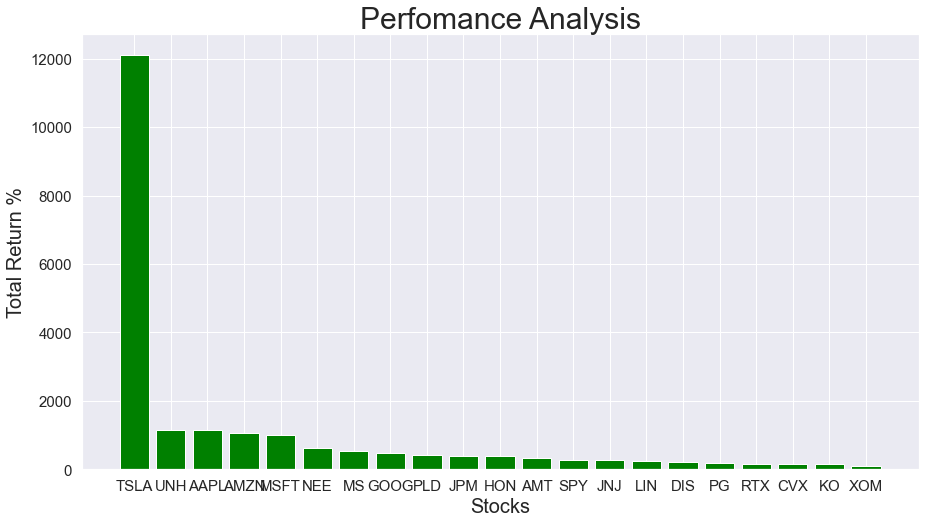

In [61]:
# Perform Analysis
plt.figure(figsize=(15,8))
plt.bar(total_return.index, total_return.values, color='green')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
plt.title('Perfomance Analysis', fontsize='30')
plt.xlabel('Stocks',fontsize='20')
plt.ylabel('Total Return %',fontsize='20')
plt.show()

# Cumulative Return

In [14]:
# Cumulative return between start date and end date
norm_df = norm(stocks, '2002-01-02','2022-01-02')
norm_df.head()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2012-01-04,1.005374,1.014454,0.991510,0.998278,1.014096,1.004313,0.999100,0.993928,1.006335,0.993727,...,0.991293,1.023534,0.997455,0.999551,0.974692,1.005224,1.001569,0.986823,1.014566,1.000233
2012-01-05,1.016535,1.026186,0.992068,0.988493,1.031062,0.990382,1.000180,0.992714,1.027354,0.989022,...,1.012437,1.033993,1.010178,0.995362,1.000000,0.995580,1.004235,0.965812,1.021363,0.997210
2012-01-06,1.027162,1.024486,1.019997,0.981335,1.041765,0.976871,0.992803,0.984062,1.018140,0.982749,...,0.988806,1.050056,0.999491,0.992967,0.984610,0.989821,1.001647,0.958333,1.025053,0.989767
2012-01-09,1.025533,1.027376,0.997375,0.992026,1.037588,0.935453,1.001080,0.985579,1.016412,0.982749,...,1.007462,1.036235,1.000678,0.997157,0.975718,0.992499,1.004079,0.970442,1.023888,0.994186


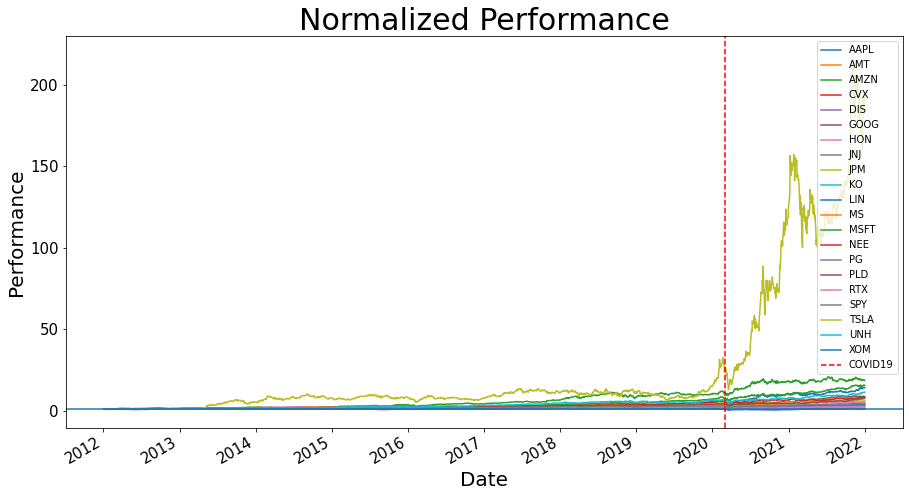

In [15]:
# Normalized cumulative return
plot_data(norm_df, 'Normalized Performance', 'Date', 'Performance')

# Cumulative Return by Sectors

#### Tech and Communication Companies

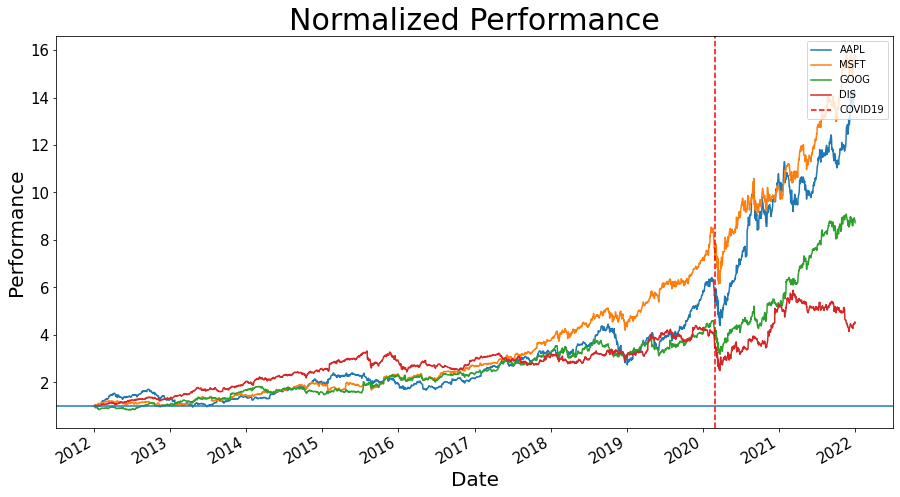

In [16]:
plot_data(norm_df[['AAPL', 'MSFT', 'GOOG','DIS']],'Normalized Performance', 'Date', 'Performance')

#### Consumer Cyclical and Defensive Companies

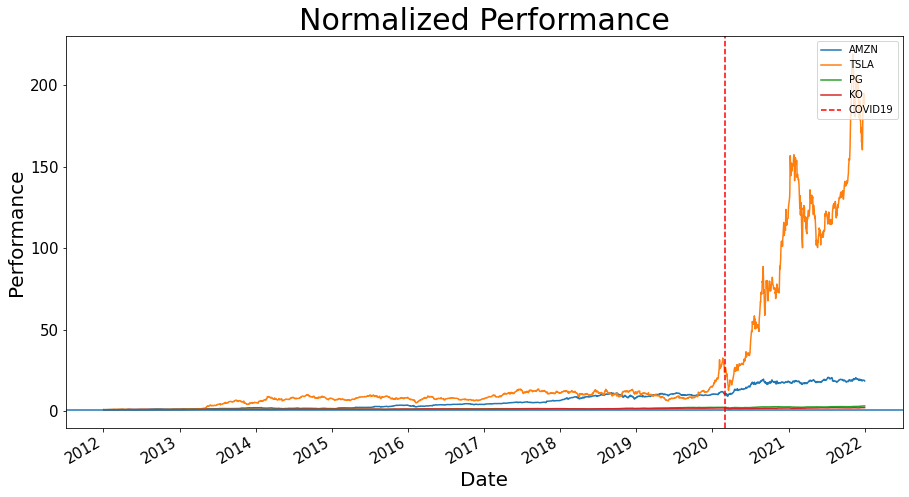

In [17]:
plot_data(norm_df[['AMZN','TSLA','PG','KO']],'Normalized Performance', 'Date', 'Performance')

#### Financial and Real State Companies

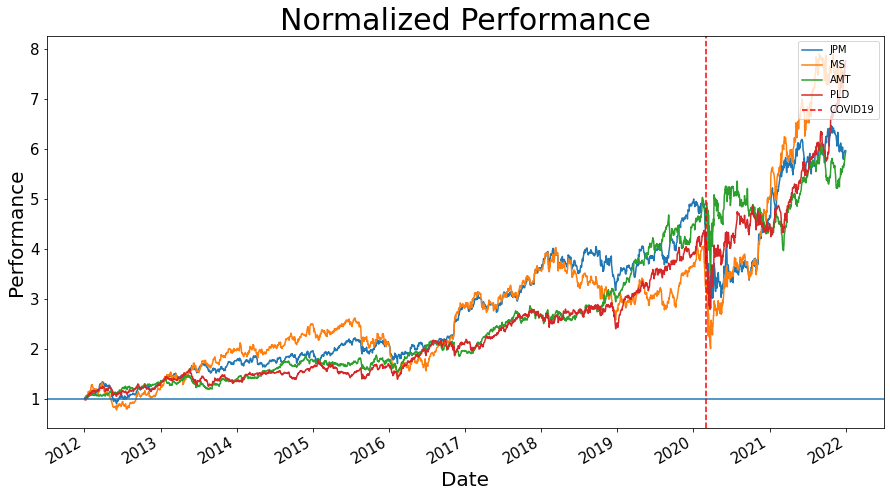

In [18]:
plot_data(norm_df[['JPM', 'MS', 'AMT','PLD']],'Normalized Performance', 'Date', 'Performance')

#### Energy, Industrials and Basic Materials Companies

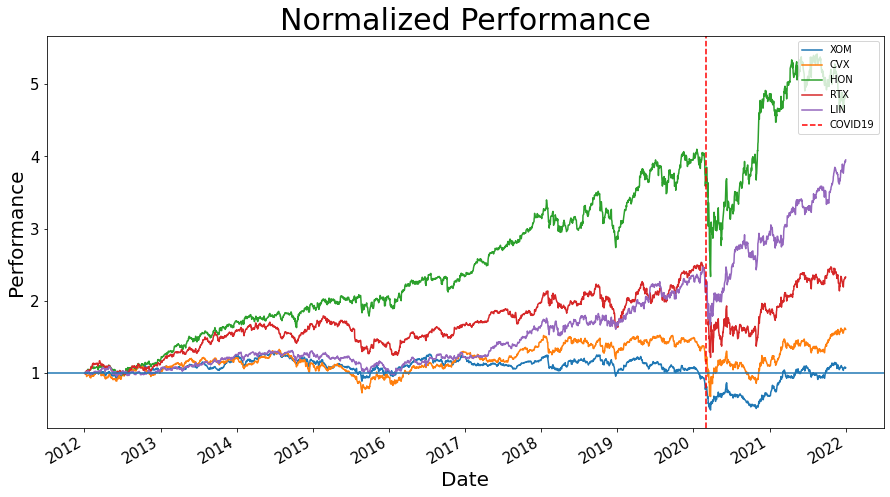

In [19]:
plot_data(norm_df[['XOM','CVX','HON','RTX', 'LIN']],'Normalized Performance', 'Date', 'Performance')

#### Healthcare and Utilities Companies

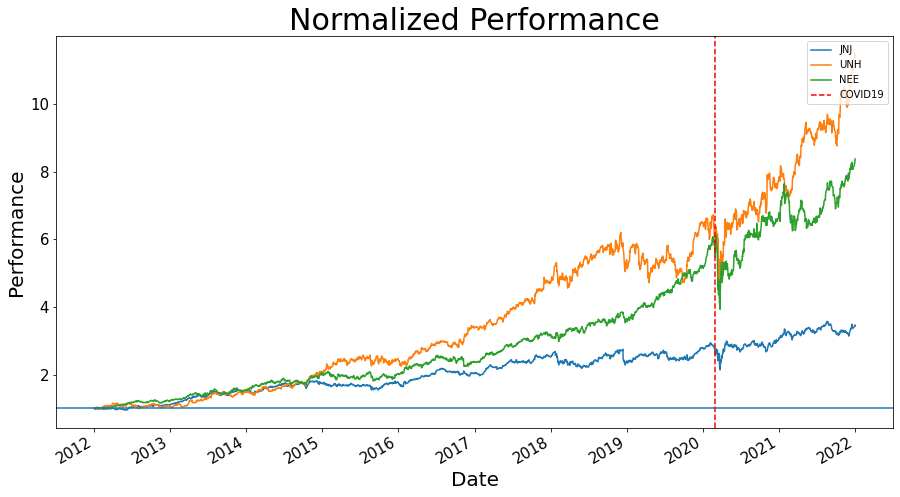

In [20]:
plot_data(norm_df[['JNJ','UNH','NEE']],'Normalized Performance', 'Date', 'Performance')

# Daily Return

In [21]:
d_return = daily_return(stocks, 1)
d_return.head()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2012-01-04,0.005374,0.014454,-0.008490,-0.001722,0.014096,0.004313,-0.000900,-0.006072,0.006335,-0.006273,...,-0.008707,0.023534,-0.002545,-0.000449,-0.025308,0.005224,0.001569,-0.013177,0.014566,0.000233
2012-01-05,0.011102,0.011565,0.000563,-0.009802,0.016731,-0.013871,0.001080,-0.001222,0.020887,-0.004734,...,0.021330,0.010219,0.012755,-0.004191,0.025965,-0.009594,0.002662,-0.021292,0.006700,-0.003022
2012-01-06,0.010454,-0.001657,0.028152,-0.007241,0.010380,-0.013642,-0.007375,-0.008715,-0.008968,-0.006343,...,-0.023341,0.015535,-0.010580,-0.002405,-0.015390,-0.005785,-0.002577,-0.007743,0.003613,-0.007463
2012-01-09,-0.001586,0.002821,-0.022178,0.010895,-0.004009,-0.042399,0.008336,0.001542,-0.001697,0.000000,...,0.018868,-0.013163,0.001188,0.004220,-0.009031,0.002706,0.002428,0.012635,-0.001137,0.004464


In [22]:
d_return.describe()

,AAPL,AMT,AMZN,CVX,DIS,GOOG,HON,JNJ,JPM,KO,...,MS,MSFT,NEE,PG,PLD,RTX,SPY,TSLA,UNH,XOM
count,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,...,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000,2725.000000
mean,0.001091,0.000640,0.001103,0.000498,0.000540,0.000786,0.000678,0.000528,0.000728,0.000388,...,0.000886,0.001017,0.000816,0.000442,0.000734,0.000483,0.000541,0.002395,0.001055,0.000388
std,0.018216,0.014759,0.020292,0.017682,0.015924,0.016679,0.014072,0.010808,0.017028,0.011181,...,0.020171,0.016595,0.013499,0.011310,0.015535,0.016101,0.010643,0.035607,0.015751,0.016324
min,-0.128647,-0.151638,-0.140494,-0.221248,-0.129846,-0.111008,-0.120868,-0.100379,-0.149649,-0.096725,...,-0.156000,-0.147390,-0.134171,-0.087374,-0.172706,-0.144765,-0.109424,-0.210628,-0.172769,-0.122248
25%,-0.007393,-0.006592,-0.008528,-0.007285,-0.006635,-0.006603,-0.005624,-0.004289,-0.007387,-0.004522,...,-0.009390,-0.006569,-0.005384,-0.004716,-0.006851,-0.006164,-0.003523,-0.014726,-0.006750,-0.006944
50%,0.000855,0.000905,0.000979,0.000553,0.000448,0.000698,0.000701,0.000444,0.000431,0.000490,...,0.000835,0.000683,0.001202,0.000484,0.001151,0.000528,0.000630,0.001411,0.001038,0.000116
75%,0.010512,0.008112,0.011175,0.008151,0.007779,0.008858,0.007288,0.005900,0.008867,0.005875,...,0.011554,0.009178,0.007230,0.005875,0.008875,0.007349,0.005453,0.019081,0.008421,0.007665
max,0.119808,0.122219,0.157457,0.227407,0.144123,0.160524,0.150683,0.079977,0.180125,0.064796,...,0.197700,0.142169,0.136904,0.120090,0.118103,0.157572,0.090603,0.243951,0.127989,0.126868


In [23]:
stds = d_return.describe().loc['std']
stds.sort_values(ascending=False)

TSLA    0.035607
AMZN    0.020292
MS      0.020171
AAPL    0.018216
CVX     0.017682
JPM     0.017028
GOOG    0.016679
MSFT    0.016595
XOM     0.016324
RTX     0.016101
DIS     0.015924
UNH     0.015751
PLD     0.015535
AMT     0.014759
HON     0.014072
LIN     0.013784
NEE     0.013499
PG      0.011310
KO      0.011181
JNJ     0.010808
SPY     0.010643
Name: std, dtype: float64

## Daily return behaviour

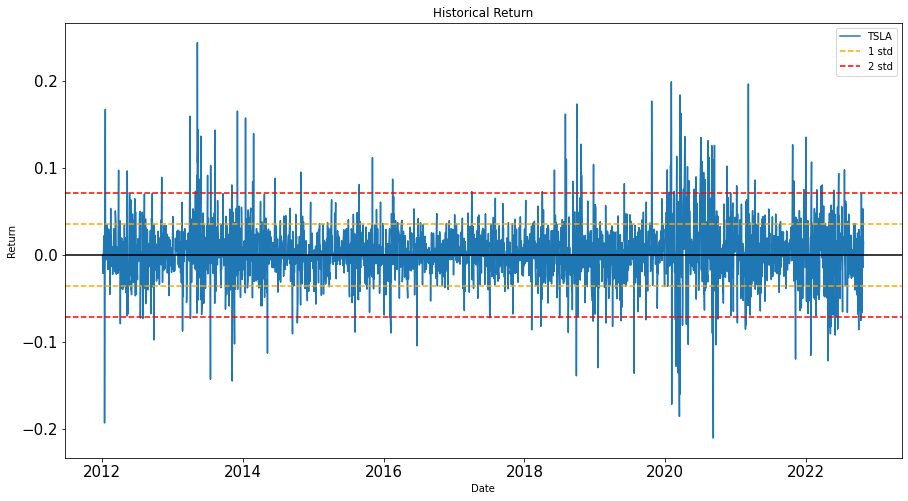

In [24]:
plot_line(d_return['TSLA'])

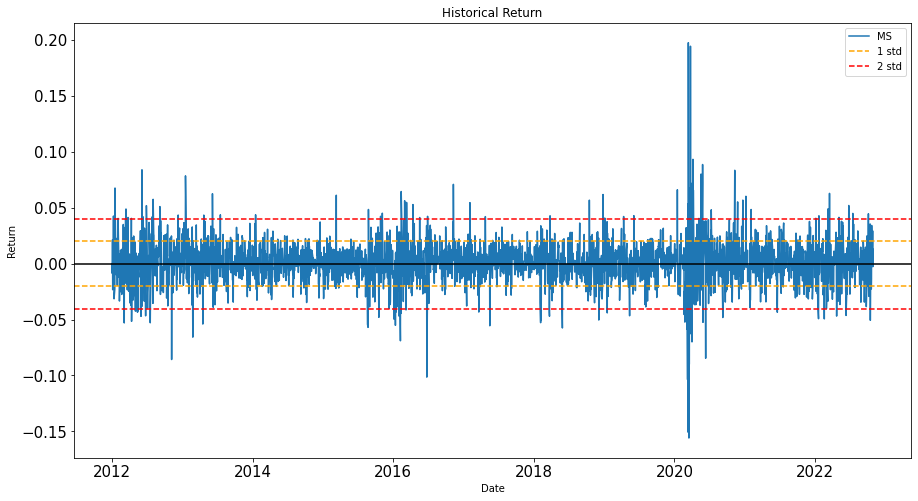

In [25]:
plot_line(d_return['MS'])

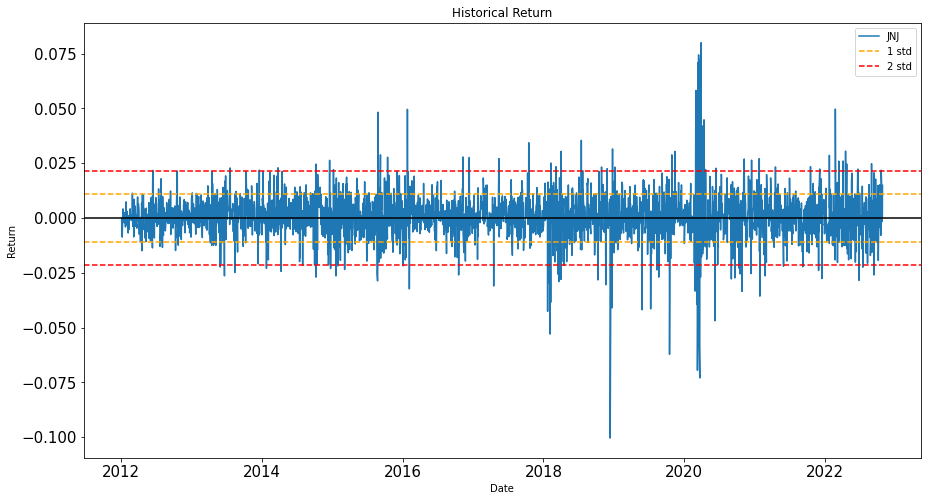

In [26]:
plot_line(d_return['JNJ'])

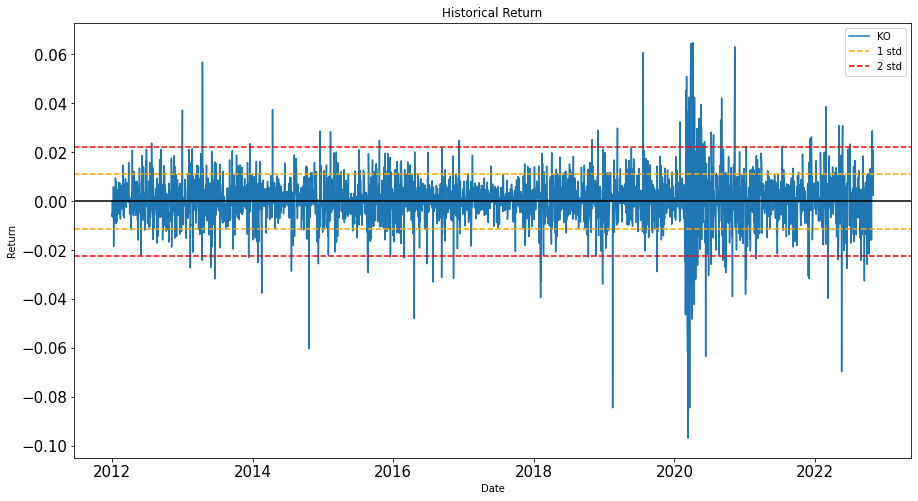

In [27]:
plot_line(d_return['KO'])

## Daily return behaviour - Histogram

The Kurtosis is: 5.587530946216504


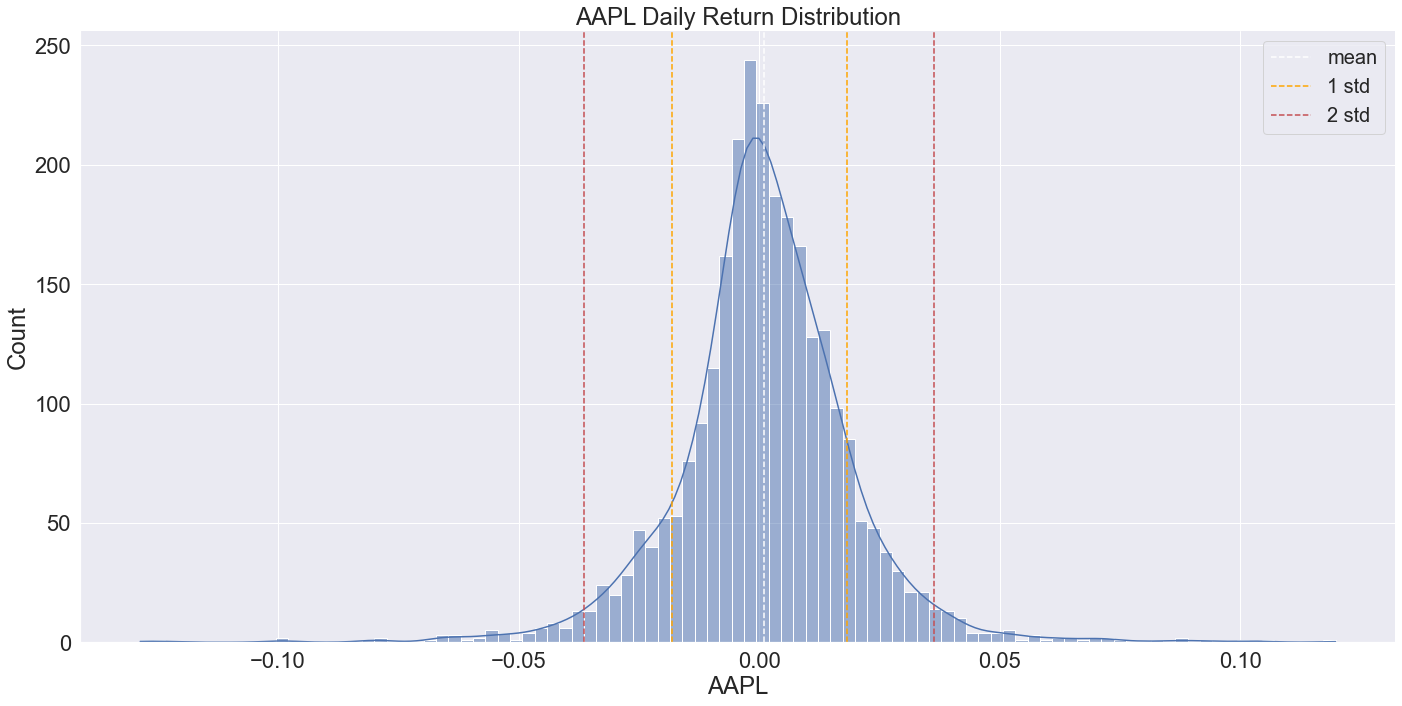

In [28]:
hist_seaborn(d_return['AAPL'])

# Scatter Plots

Beta Coeficient between SPY and JPM is 1.1848609505098908
Alpha Coeficient between SPY and JPM is 8.711893848724941e-05


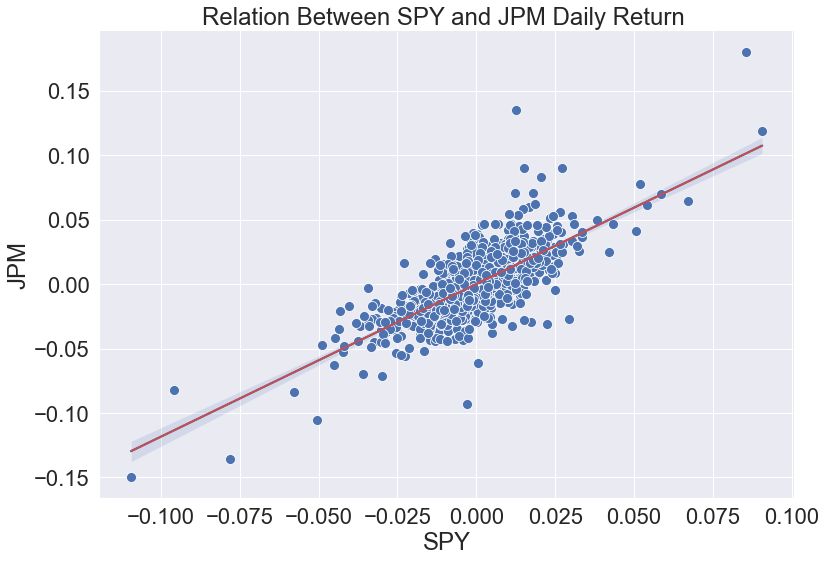

In [29]:
scatter_searborn(d_return, 'SPY', 'JPM')

Beta Coeficient between SPY and JNJ is 0.6122094274931641
Alpha Coeficient between SPY and JNJ is 0.00019659030094191333


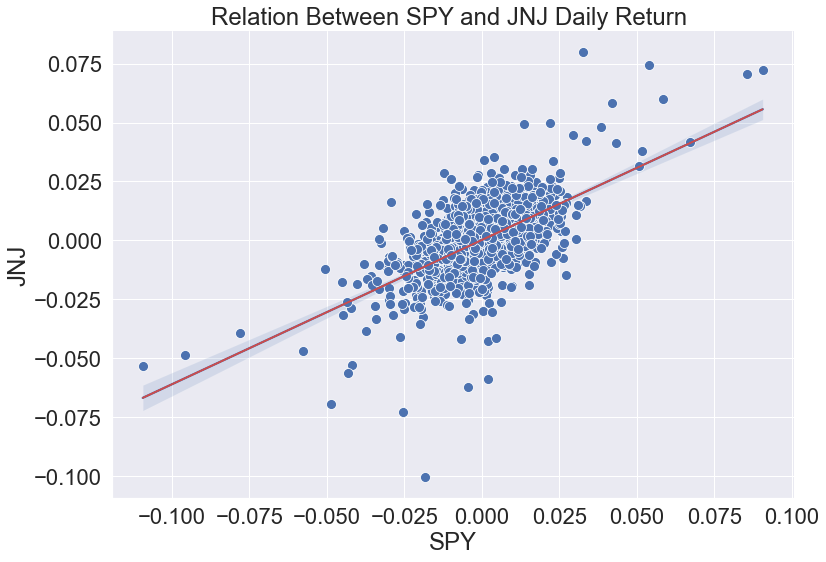

In [30]:
scatter_searborn(d_return, 'SPY', 'JNJ')

# Correlation

In [31]:
d_return_corr = d_return.corr(method='pearson')

<AxesSubplot:>

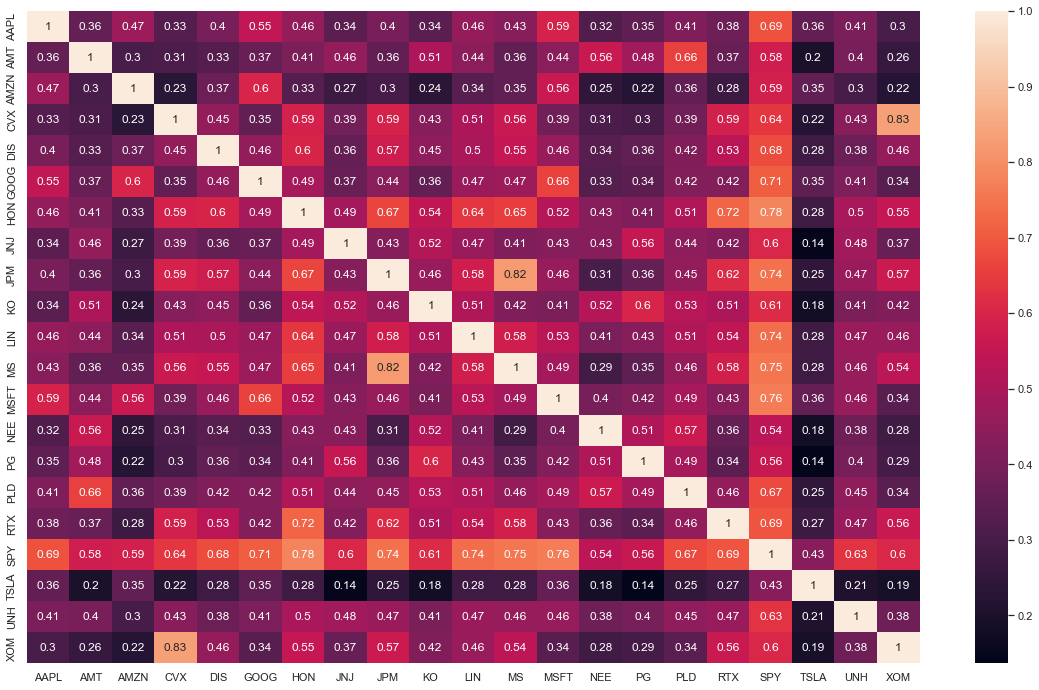

In [32]:
sns.set(rc = {'figure.figsize':(20,12)})
sns.heatmap(d_return_corr, annot=True)

# Technical Analysis

In [33]:
stocks['AAPL'].name

'AAPL'

In [34]:
def SMA_plot(df, n1, n2, n3):
    sma200 = rolling_mean(df, n1)
    sma50 = rolling_mean(df, n2)
    sma10 = rolling_mean(df, n3)
    print(len(df))
    print(len(sma200))
    
    list_sma200 = sma200.values.tolist()
    list_sma50 = sma50.values.tolist()
    list_sma10 = sma10.values.tolist()
    close = df.values.tolist()
    dates = df.index.values
    print(len(list_sma200))
    matplotlib.rc('xtick', labelsize=15) 
    matplotlib.rc('ytick', labelsize=15) 
    plt.plot(dates, list_sma200, color='red', linestyle='dashed')
    plt.plot(dates, list_sma50, color='orange')
    plt.plot(dates, list_sma10, color='blue')
    plt.scatter(dates, close, s=5, color='green')    
    plt.title(df.name, fontsize='30')
    plt.xlabel('Date', fontsize='20')
    plt.ylabel('Price', fontsize='20')
    print(len(list_sma50))
    print(len(dates)) 

2725
2725
2725
2725
2725


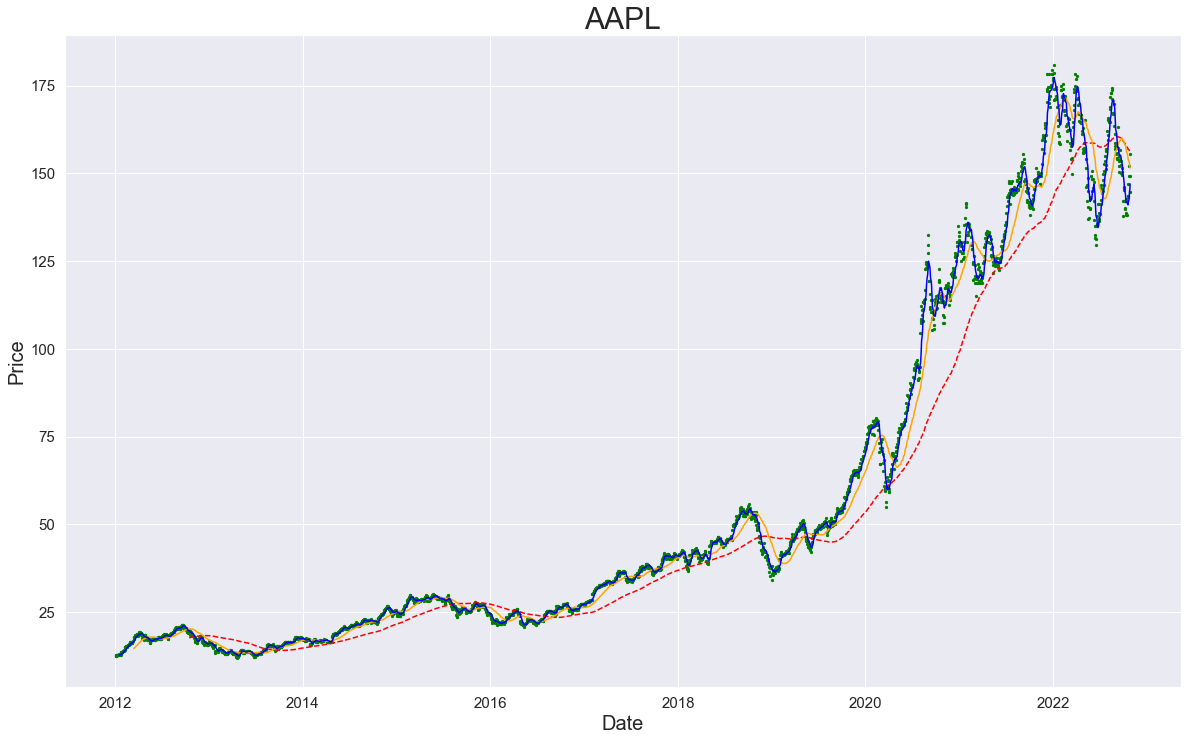

In [35]:
SMA_plot(stocks.AAPL, 200,50,10)

2725
2725
2725
2725
2725


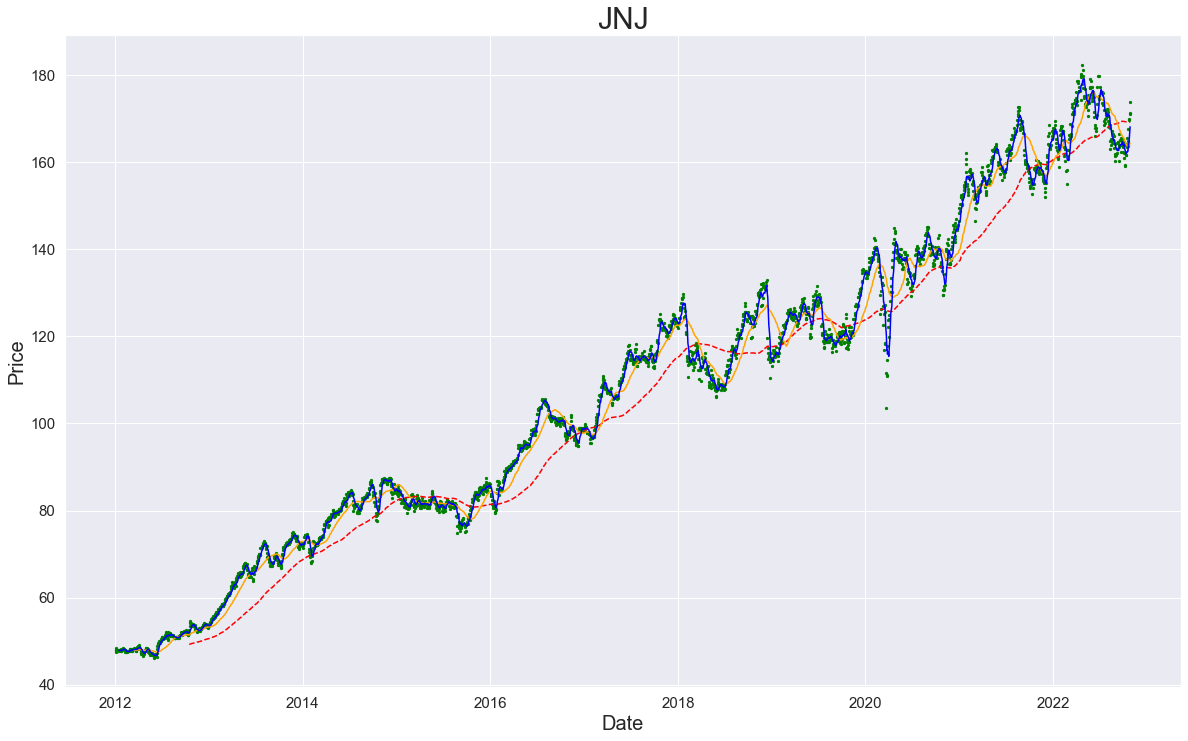

In [36]:
SMA_plot(stocks.JNJ, 200,50,10)

In [37]:
def BB_plot(df, periods, n_std):
    
    sma, upper, lower = bollinger_bands(df, periods, n_std)
    sma_list = sma.values.tolist()
    upper_list = upper.values.tolist()
    lower_list = lower.values.tolist()
    close = df.values.tolist()
    dates = df.index.values       
    plt.plot(dates, upper, color='red', linestyle='dashed')
    plt.plot(dates, lower, color='red', linestyle='dashed')
    plt.plot(dates, sma, color='blue')
    plt.scatter(dates, close, s=5, color='green')    
    plt.title(df.name, fontsize='30')
    plt.xlabel('Date', fontsize='20')
    plt.ylabel('Price', fontsize='20')


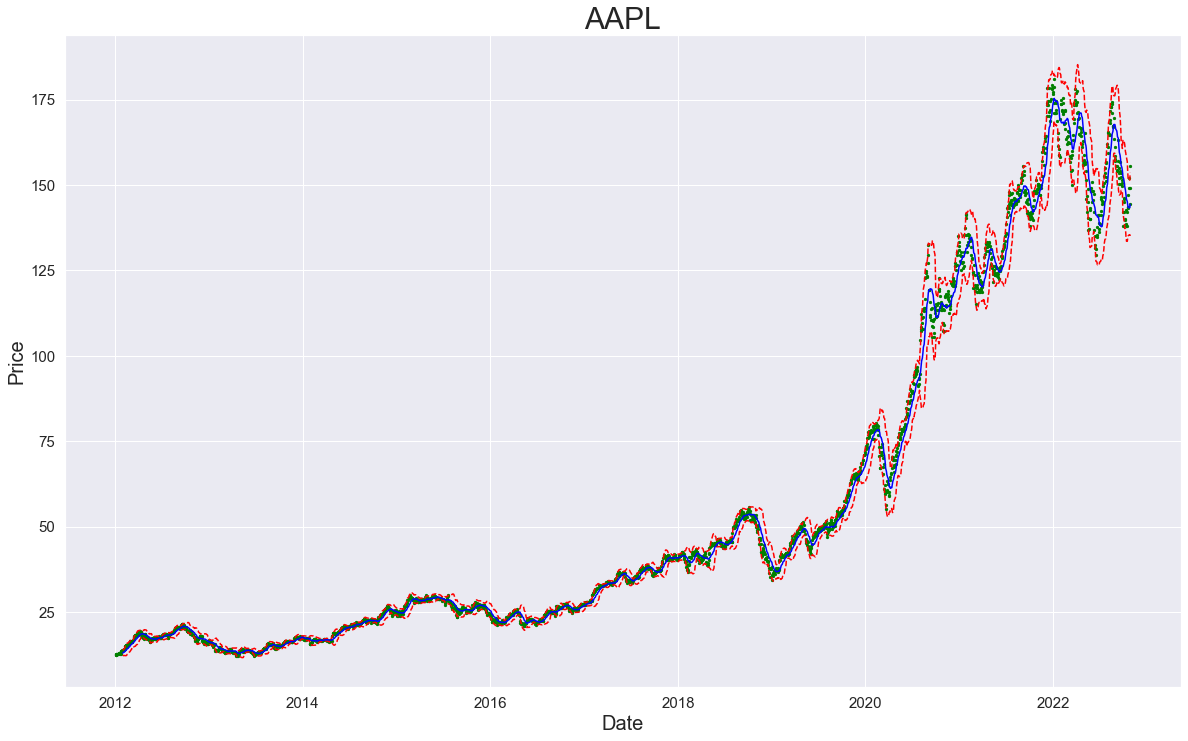

In [38]:
BB_plot(stocks.AAPL, 20, 2)

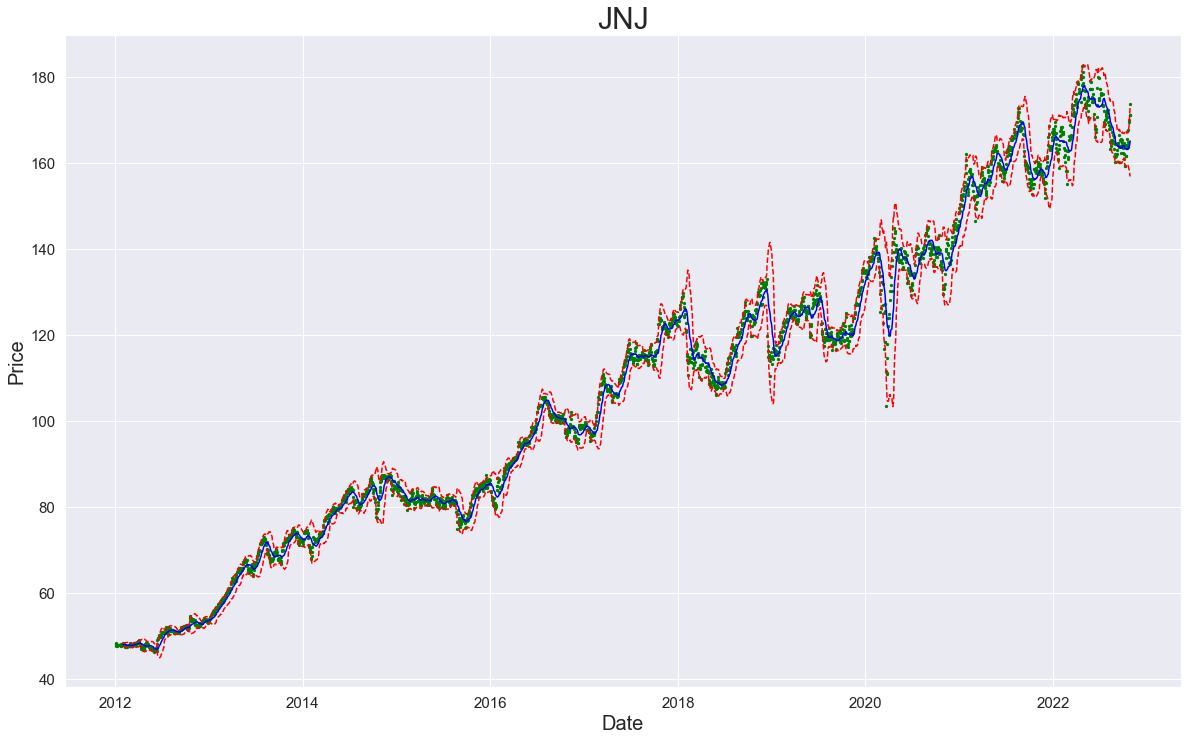

In [39]:
BB_plot(stocks.JNJ, 20, 2)

# Machine Learn

# Linear Regression

In [40]:
data = get_data(['^RUI'], '2012-03-11', '2022-07-10')
data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-12,759.429993,760.619995,756.840027,759.130005,759.130005,0
2012-03-13,761.450012,773.030029,761.450012,772.979980,772.979980,0
2012-03-14,773.190002,774.679993,769.280029,771.630005,771.630005,0
2012-03-15,772.380005,776.469971,770.739990,776.419983,776.419983,0
2012-03-16,776.559998,778.099976,775.640015,777.130005,777.130005,0


In [41]:
# Other Features
data['RSI'] = ta.rsi(data['Adj Close'], lenghth=15)
data['EMAF'] = ta.ema(data['Adj Close'], lenght=20)
data['EMAM'] = ta.ema(data['Adj Close'], lenght=100)
data['EMAS'] = ta.ema(data['Adj Close'], lenght=150)
data['BBupper 2'] = bollinger_bands(data['Adj Close'], 2, 2)[1]
data['BBlower 2'] = bollinger_bands(data['Adj Close'], 2, 2)[2]
#defining Predict as the next Adj Close Price
data['Predict Next Day'] = data['Adj Close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace=True)
data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [42]:
data_set = data.iloc[:, 0:11]#.values
pd.set_option('display.max_columns', None)

data_set.head()

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,BBupper 2,BBlower 2,Predict Next Day
0,777.419983,780.429993,775.049988,778.919983,62.815527,776.920039,776.920039,776.920039,781.397466,773.732539,783.150024
1,778.270020,786.679993,776.669983,783.150024,67.135117,778.052764,778.052764,778.052764,787.017186,775.052822,781.989990
2,784.520020,784.840027,777.140015,781.989990,64.908263,778.768623,778.768623,778.768623,784.210543,780.929471,773.719971
3,779.679993,779.679993,771.059998,773.719971,51.733706,777.850686,777.850686,777.850686,789.550554,766.159407,773.130005
4,773.469971,775.210022,770.559998,773.130005,50.939388,776.992381,776.992381,776.992381,774.259325,772.590650,764.270020


In [43]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1)) #will rescale the values between 0 and 1
data_set_scaled = sc.fit_transform(data_set)

data_set_scaled

array([[0.03751187, 0.03672186, 0.0389696 , ..., 0.03753484, 0.04310646,
        0.03981122],
       [0.03794623, 0.03990466, 0.03979841, ..., 0.04034277, 0.04377869,
        0.03921799],
       [0.04113993, 0.03896766, 0.04003889, ..., 0.03894041, 0.04677085,
        0.03498884],
       ...,
       [0.70953206, 0.71180135, 0.69323641, ..., 0.7020073 , 0.71530685,
        0.71854987],
       [0.71648658, 0.72114597, 0.71258568, ..., 0.70375493, 0.7190605 ,
        0.73588072],
       [0.72148921, 0.73333236, 0.72499231, ..., 0.73399938, 0.70791481,
        0.73454595]])

In [44]:
def train_test_split_custom(data, size):
    
    test_size = int(data.shape[0] * size)
    x_train = data[:test_size,0:-1]
    y_train = data[:test_size,-1]
    x_test = data[test_size:,0:-1]
    y_test = data[test_size:,-1]
    return x_train, x_test, y_train, y_test

In [45]:
x_train, x_test, y_train, y_test = train_test_split_custom(data_set_scaled, .8)

In [46]:
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [47]:
y_pred = regressor.predict(x_test)
np.set_printoptions(precision=2) # Display any numerical value with 2 decimal
compared = np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test),1)),1)
print(compared)

[[0.52 0.52]
 [0.52 0.52]
 [0.52 0.53]
 ...
 [0.71 0.72]
 [0.72 0.74]
 [0.73 0.73]]


In [48]:
# MSE
mean_squared_error(y_test, y_pred)

0.00017575422298514204

In [49]:
# RMSE
mean_squared_error(y_test, y_pred, squared=False)

0.013257232855507292

In [50]:
# R squared score (R² score)
# A high r2_score reflects a good model performance on the test set.
r2_score(y_test, y_pred)

0.9897841881616146

In [51]:
for i in range(50):
    print(y_pred[i], y_test[i], f'Predictions accuracy {round(float((y_pred[i] / y_test[i] - 1) * 100), 2)}% of actual value')

0.5201959905469167 0.5169779189686436 Predictions accuracy 0.62% of actual value
0.5185763274797055 0.5225775420481273 Predictions accuracy -0.77% of actual value
0.5211080526139009 0.5261265751905085 Predictions accuracy -0.95% of actual value
0.5265741130458625 0.5027000724282923 Predictions accuracy 4.75% of actual value
0.5062425565240596 0.5126106848976009 Predictions accuracy -1.24% of actual value
0.5093639583519745 0.49192525200473114 Predictions accuracy 3.54% of actual value
0.49503818992611354 0.5040603697073388 Predictions accuracy -1.79% of actual value
0.5003417956882703 0.5176069105423976 Predictions accuracy -3.34% of actual value
0.5148519921963572 0.5223372068398152 Predictions accuracy -1.43% of actual value
0.5221949560005192 0.5265765950649818 Predictions accuracy -0.83% of actual value
0.52759328003279 0.5408339662940795 Predictions accuracy -2.45% of actual value
0.5384921081991885 0.5312915348789593 Predictions accuracy 1.36% of actual value
0.5340705276122688 0

<AxesSubplot:>

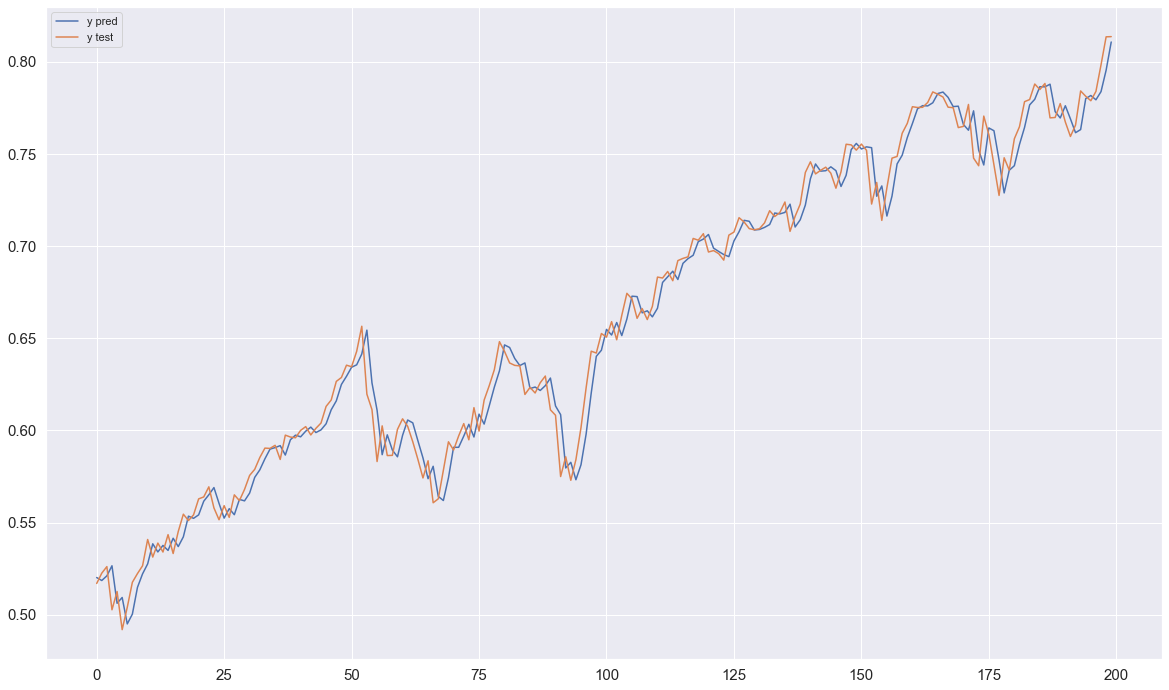

In [52]:
df = pd.DataFrame(compared, columns=['y pred', 'y test'])
df.iloc[0:200,:].plot()

# KNN

In [53]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(x_train, y_train)


KNeighborsRegressor(n_neighbors=2)

<AxesSubplot:>

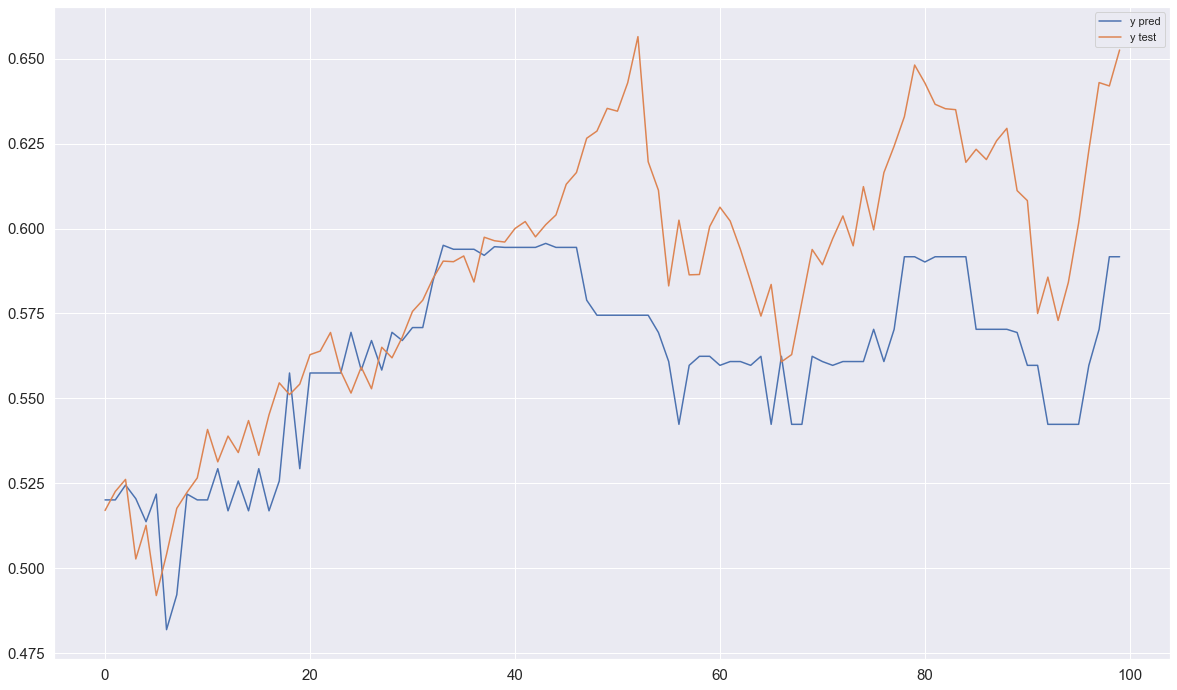

In [54]:
knn_ypred = knn.predict(x_test)
knn_compared = np.concatenate((knn_ypred.reshape(len(knn_ypred), 1), y_test.reshape(len(y_test),1)),1)
knn_df = pd.DataFrame(knn_compared, columns=['y pred', 'y test'])
knn_df.iloc[0:100,:].plot()

In [55]:
for i in range(50):
    print(y_pred[i], y_test[i], f'Predictions accuracy {round(float((y_pred[i] / y_test[i] - 1) * 100), 2)}% of actual value')

0.5201959905469167 0.5169779189686436 Predictions accuracy 0.62% of actual value
0.5185763274797055 0.5225775420481273 Predictions accuracy -0.77% of actual value
0.5211080526139009 0.5261265751905085 Predictions accuracy -0.95% of actual value
0.5265741130458625 0.5027000724282923 Predictions accuracy 4.75% of actual value
0.5062425565240596 0.5126106848976009 Predictions accuracy -1.24% of actual value
0.5093639583519745 0.49192525200473114 Predictions accuracy 3.54% of actual value
0.49503818992611354 0.5040603697073388 Predictions accuracy -1.79% of actual value
0.5003417956882703 0.5176069105423976 Predictions accuracy -3.34% of actual value
0.5148519921963572 0.5223372068398152 Predictions accuracy -1.43% of actual value
0.5221949560005192 0.5265765950649818 Predictions accuracy -0.83% of actual value
0.52759328003279 0.5408339662940795 Predictions accuracy -2.45% of actual value
0.5384921081991885 0.5312915348789593 Predictions accuracy 1.36% of actual value
0.5340705276122688 0

# LSTM

In [56]:
X = []
n_features = len(data_set.columns)
back_days = 50
print(data_set_scaled.shape[0])
for j in range(n_features):
    X.append([])
    for i in range(back_days, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-back_days:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(data_set_scaled[back_days:,-1])
y=np.reshape(yi,(len(yi),1))



2583


In [57]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
X_train.shape

2026


(2026, 50, 11)

In [58]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

np.random.seed(10)

lstm_input = Input(shape=(back_days, n_features), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=50, shuffle=True, validation_split = 0.1)

Epoch 1/50
122/122 [==============================] - 6s 27ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 2/50
122/122 [==============================] - 3s 24ms/step - loss: 1.1425e-04 - val_loss: 0.0011
Epoch 3/50
122/122 [==============================] - 3s 23ms/step - loss: 1.0992e-04 - val_loss: 0.0010
Epoch 4/50
122/122 [==============================] - 3s 23ms/step - loss: 9.7474e-05 - val_loss: 9.8885e-04
Epoch 5/50
122/122 [==============================] - 3s 23ms/step - loss: 8.6595e-05 - val_loss: 9.8684e-04
Epoch 6/50
122/122 [==============================] - 3s 23ms/step - loss: 7.6481e-05 - val_loss: 9.4272e-04
Epoch 7/50
122/122 [==============================] - 3s 22ms/step - loss: 8.2586e-05 - val_loss: 0.0010
Epoch 8/50
122/122 [==============================] - 3s 23ms/step - loss: 7.9589e-05 - val_loss: 8.7224e-04
Epoch 9/50
122/122 [==============================] - 3s 23ms/step - loss: 7.2797e-05 - val_loss: 9.3008e-04
Epoch 10/50
122/122 [==================

In [59]:
from math import ceil
y_pred = model.predict(X_test)

for i in range(50):
    print(y_pred[i], y_test[i], f'Predictions accuracy {round(float((y_pred[i] / y_test[i] - 1) * 100), 2)}% of actual value')

16/16 [==============================] - 1s 12ms/step
[0.53] [0.54] Predictions accuracy -2.12% of actual value
[0.54] [0.53] Predictions accuracy 1.1% of actual value
[0.54] [0.54] Predictions accuracy 0.19% of actual value
[0.54] [0.53] Predictions accuracy 1.05% of actual value
[0.54] [0.54] Predictions accuracy -0.44% of actual value
[0.54] [0.53] Predictions accuracy 1.71% of actual value
[0.54] [0.55] Predictions accuracy -0.37% of actual value
[0.54] [0.55] Predictions accuracy -1.9% of actual value
[0.55] [0.55] Predictions accuracy 0.09% of actual value
[0.56] [0.55] Predictions accuracy 0.47% of actual value
[0.56] [0.56] Predictions accuracy -1.0% of actual value
[0.56] [0.56] Predictions accuracy -0.31% of actual value
[0.57] [0.57] Predictions accuracy -0.43% of actual value
[0.57] [0.56] Predictions accuracy 2.39% of actual value
[0.57] [0.55] Predictions accuracy 3.38% of actual value
[0.56] [0.56] Predictions accuracy 0.39% of actual value
[0.56] [0.55] Predictions accu

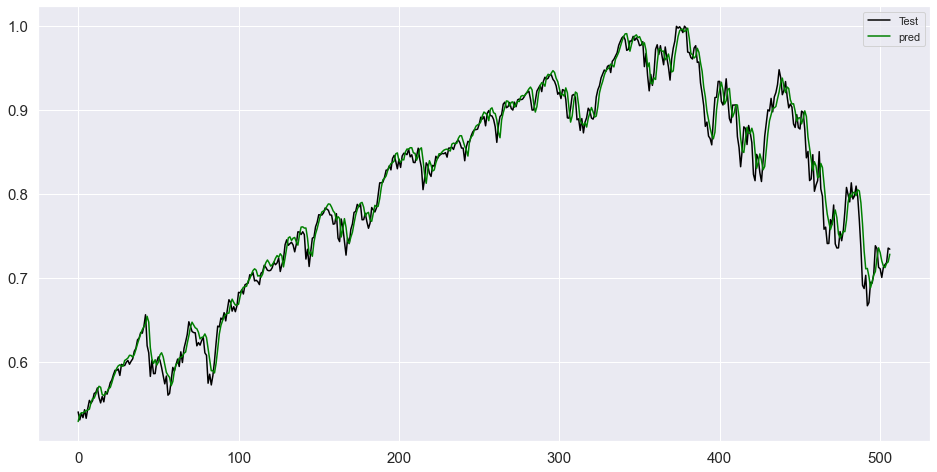

In [60]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()